In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import markov_sim as markov
import json
import os
from datetime import datetime
from datetime import timedelta
from re import sub
from dateutil import  parser
from scipy.signal import periodogram
from sktime.transformations.series.outlier_detection import HampelFilter
from hampel import hampel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


2023-04-20 18:21:37.018529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(10, 10)
yes
(10, 10)
   0-0  0-1  1-0  1-1       2-0  0-2      2-1       1-2   V1   V2
0  0.0  0.0  0.0  0.0  0.167949  0.0  0.66022  0.171831  0.0  0.0


In [2]:
file = '1.145385390.json'

for line in open(file, 'r'):
    data_list.append(json.loads(line))

with open(file, 'r') as f:
    top = f.readline()
    top = json.loads(top)

runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df = df.resample('500ms').last()
    print(df)
    return df

def get_best_pricevol(runner_list, price, vol):

    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))

    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):

    end_time = end + pd.Timedelta(45, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back vol': dt_shape, 'lay vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    df_back = df['back'].resample('500ms').last().rolling('45S').mean().shift(int(- 30 / .5))
    df_lay = df['lay'].resample('500ms').last().rolling('45S').mean().shift(int(- 30 / .5))
    df_back_vol = df['back vol'].resample('500ms').mean().rolling('45S').mean().shift(int(- 45 / .5))
    df_lay_vol = df['lay vol'].resample('500ms').mean().rolling('45S').mean().shift(int(- 45 / .5))
    df = pd.concat([df_back, df_lay, df_back_vol, df_lay_vol], axis=1)

    df = df.loc[start:end]
    df['back-lay avg'] = df[['back', 'lay']].mean(axis=1)
    df['spread'] = df['back'] - df['lay']
    df['uncertainty'] = df['spread'] / df['back-lay avg']
    df_pup = df['back vol'] / ( df['back vol'] + df['lay vol'] )
    df_pup.name = 'pup'
    df = pd.concat([df, df_pup], axis=1)
    df.fillna(method='ffill', inplace=True)

    return df


#
# def calc_score(p, q, current_score, implied_odds):
#     for m in implied_odds:
#         if current_score is '0-0':
#             s1 = '15-0'
#             s2 = '0-15'
#         elif current_score is '15-0':
#             s1 = '30-0'
#             s2 = '15-15'
#         elif current_score is '0-15':
#             s1 = '15-15'
#             s2 = '0-30'
#         elif current_score is '15-15':
#             s1 = '30-15'
#             s2 = '15-30'
#         elif current_score is '30-0':
#             s1 = '40-0'
#             s2 = '30-15'
#         elif current_score is '0-30':
#             s1 = '15-30'
#             s2 = '0-40'
#         elif current_score is '30-15':
#             s1 = '40-15'
#             s2 = '30-30'
#         elif current_score is '15-30':
#             s1 = '30-30'
#             s2 = '15-40'
#         elif current_score is '30-30':
#             s1 = '40-30'
#             s2 = '30-40'
#         elif current_score is '40-15':
#             s1 = 'Win'
#             s2 = '40-30'
#         elif current_score is '15-40':
#             s1 = '30-40'
#             s2 = 'Lose'
#         elif current_score is '15-40':
#             s1 = '30-40'
#             s2 = 'Lose'
#         m1 = markov.tennis_model(p, q, )
#         m2 =
#         if m > m1:
#             s = s1
#         elif = m > m2:
#             s = s2



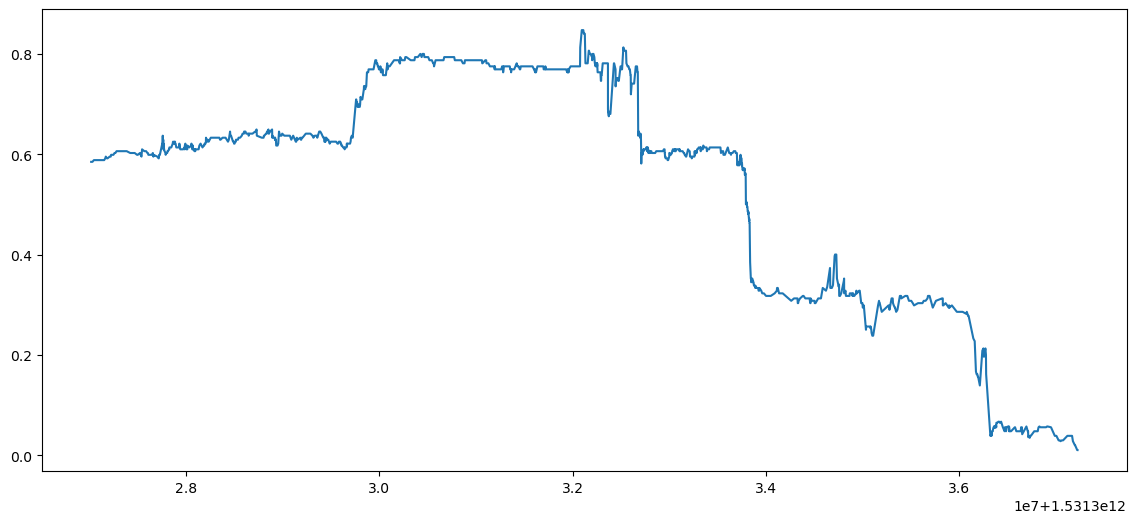

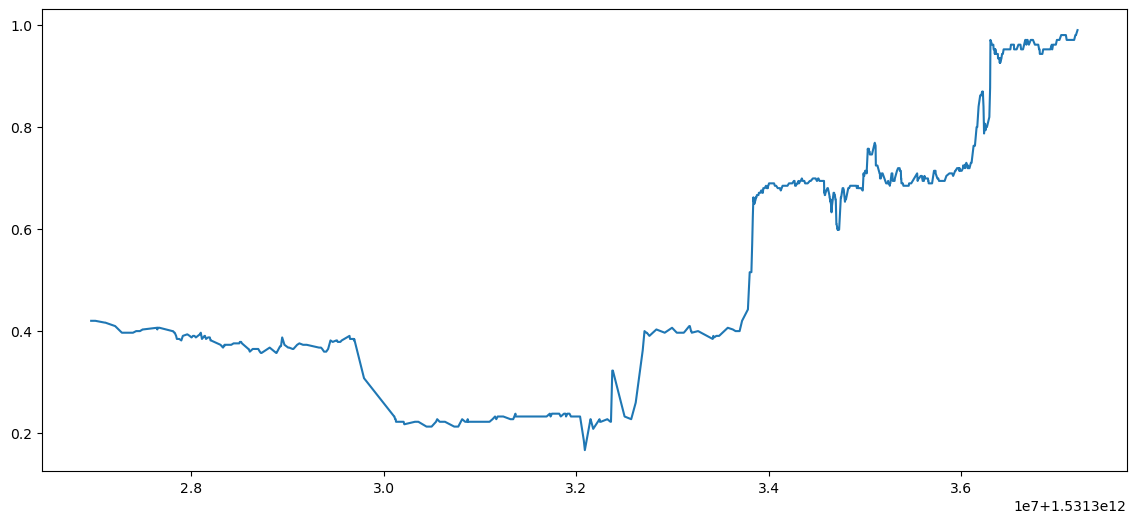

In [3]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [4]:
df = odds_avg(runner_odds_1, runner_odds_2)

                         runner 1  1 - runner 2       avg
2018-07-11 16:36:43.500  0.584795      0.579832  0.582314
2018-07-11 16:36:44.000  0.584795      0.579850  0.582323
2018-07-11 16:36:44.500  0.584795      0.579868  0.582332
2018-07-11 16:36:45.000  0.584795      0.579887  0.582341
2018-07-11 16:36:45.500  0.584795      0.579905  0.582350
...                           ...           ...       ...
2018-07-11 19:27:00.000  0.010000      0.009901  0.009950
2018-07-11 19:27:00.500  0.010000      0.009901  0.009950
2018-07-11 19:27:01.000  0.010000      0.009901  0.009950
2018-07-11 19:27:01.500  0.010000      0.009901  0.009950
2018-07-11 19:27:02.000  0.010000      0.009901  0.009950

[20438 rows x 3 columns]


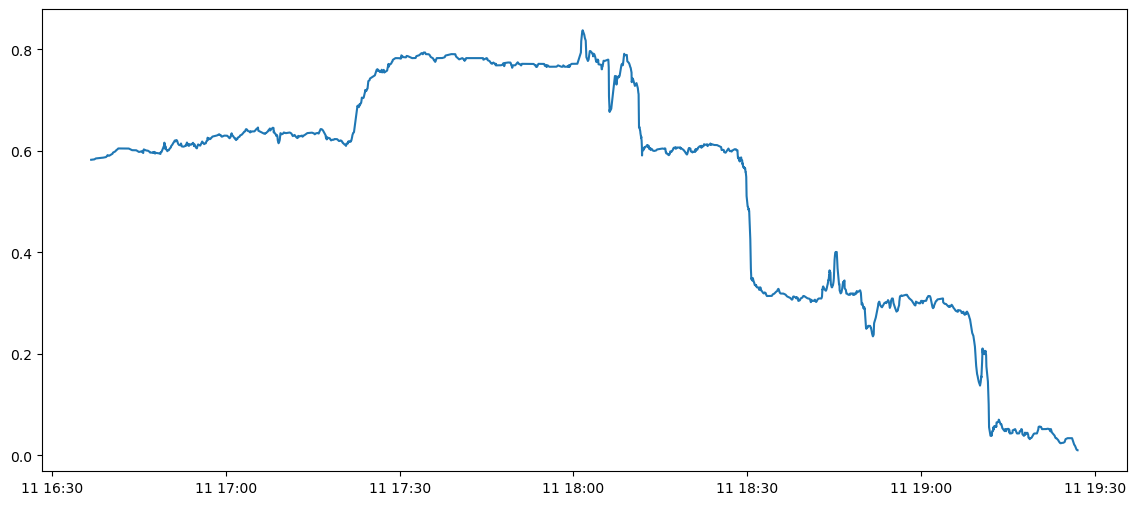

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])

In [6]:
start = df.first_valid_index()
end = df.last_valid_index()
df_runner_1 = best_available_df(runner_list_1, start, end)
print(df_runner_1)

                              back       lay    back vol      lay vol  \
2018-07-11 16:36:43.500   1.718159  1.710000  177.369300  3906.190947   
2018-07-11 16:36:44.000   1.718045  1.709964  178.599744  3940.680159   
2018-07-11 16:36:44.500   1.717929  1.709753  179.589915  3974.325338   
2018-07-11 16:36:45.000   1.717811  1.709375  180.362526  4007.107575   
2018-07-11 16:36:45.500   1.717692  1.708838  180.927256  4039.026871   
...                            ...       ...         ...          ...   
2018-07-11 19:27:00.000  40.000000  4.461368    5.580000    21.480000   
2018-07-11 19:27:00.500  40.000000  4.468511    5.580000    21.480000   
2018-07-11 19:27:01.000  40.000000  4.474926    5.580000    21.480000   
2018-07-11 19:27:01.500  40.000000  4.480611    5.580000    21.480000   
2018-07-11 19:27:02.000  40.000000  4.485568    5.580000    21.480000   

                         back-lay avg     spread  uncertainty       pup  
2018-07-11 16:36:43.500      1.714079   0.008159 

In [7]:
df_runner_2 = best_available_df(runner_list_2, start, end)
print(df_runner_2)

                             back       lay     back vol      lay vol  \
2018-07-11 16:36:43.500  2.404757  2.338303   145.977247  1252.346288   
2018-07-11 16:36:44.000  2.405201  2.338677   148.447978  1252.773816   
2018-07-11 16:36:44.500  2.405659  2.339439   150.924447  1255.161661   
2018-07-11 16:36:45.000  2.406129  2.340385   153.406652  1259.593670   
2018-07-11 16:36:45.500  2.406613  2.340892   155.894595  1266.069845   
...                           ...       ...          ...          ...   
2018-07-11 19:27:00.000  1.037114  1.010000  1833.277196   763.160000   
2018-07-11 19:27:00.500  1.037558  1.010000  1844.192700   763.160000   
2018-07-11 19:27:01.000  1.038003  1.010000  1857.315478   763.160000   
2018-07-11 19:27:01.500  1.038447  1.010000  1874.104737   763.160000   
2018-07-11 19:27:02.000  1.038892  1.010000  1894.560478   763.160000   

                         back-lay avg    spread  uncertainty       pup  
2018-07-11 16:36:43.500      2.371530  0.066454   

                         ltp odds  back lay odds
2018-07-11 16:36:43.500  0.582314       0.580867
2018-07-11 16:36:44.000  0.582323       0.580917
2018-07-11 16:36:44.500  0.582332       0.580999
2018-07-11 16:36:45.000  0.582341       0.581104
2018-07-11 16:36:45.500  0.582350       0.581203
...                           ...            ...
2018-07-11 19:27:00.000  0.009950       0.033999
2018-07-11 19:27:00.500  0.009950       0.034101
2018-07-11 19:27:01.000  0.009950       0.034204
2018-07-11 19:27:01.500  0.009950       0.034307
2018-07-11 19:27:02.000  0.009950       0.034410

[20438 rows x 2 columns]


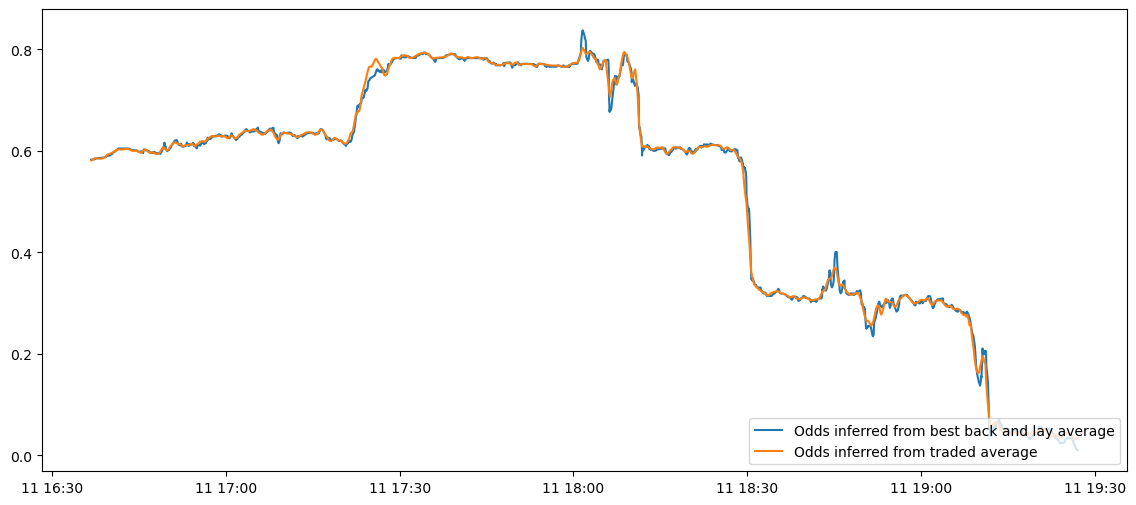

In [8]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
print(df_odds)
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

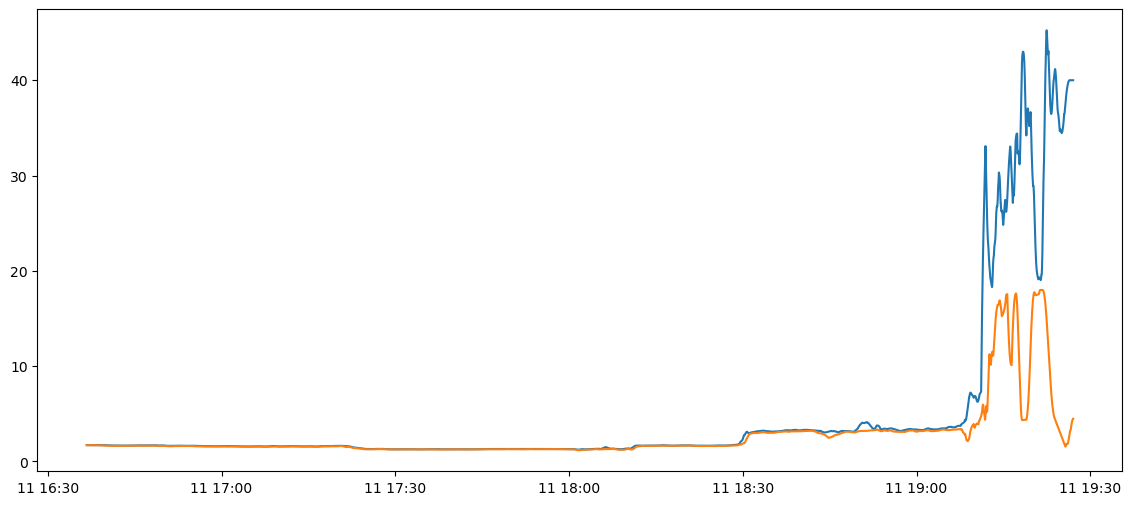

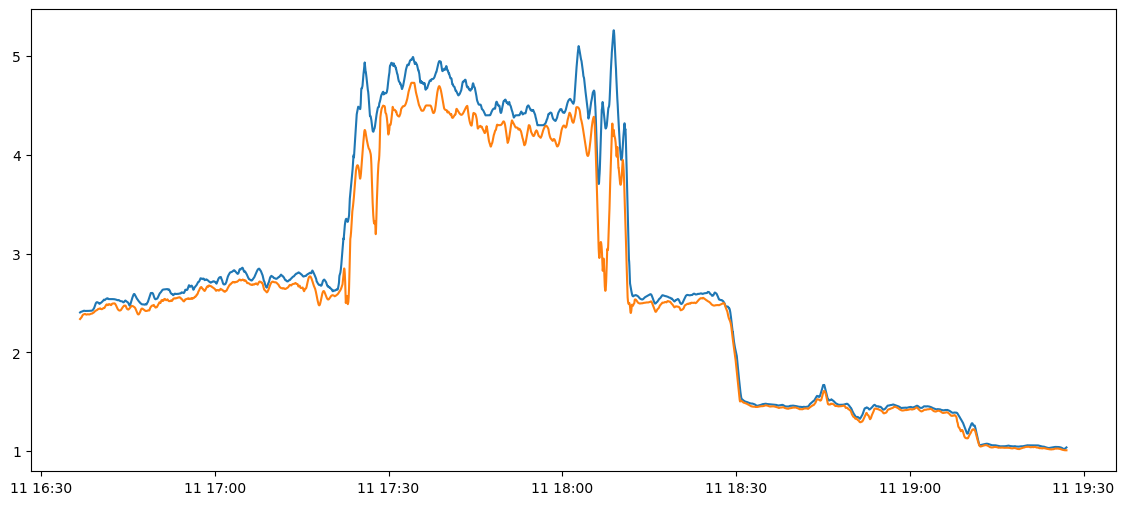

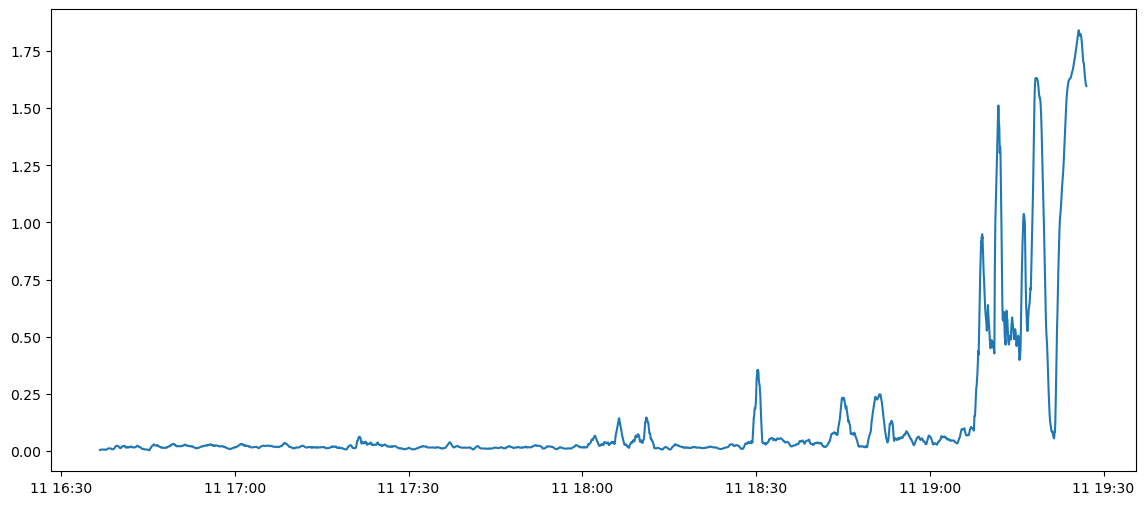

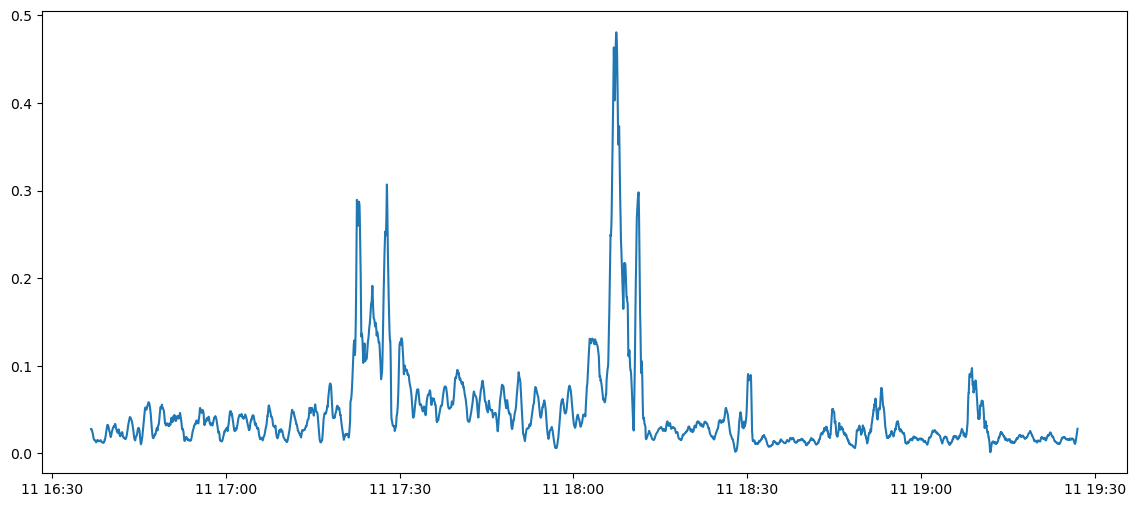

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

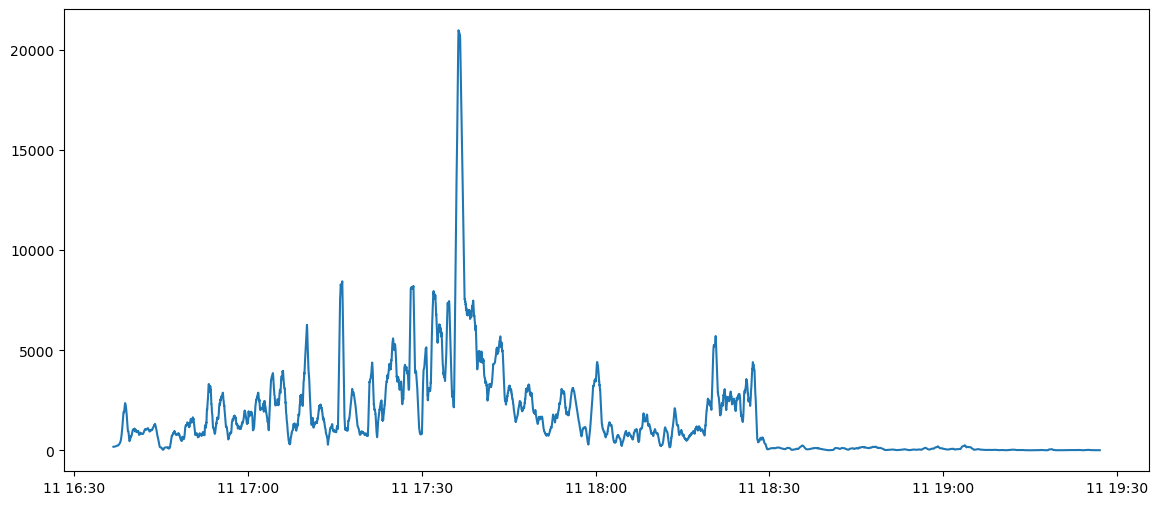

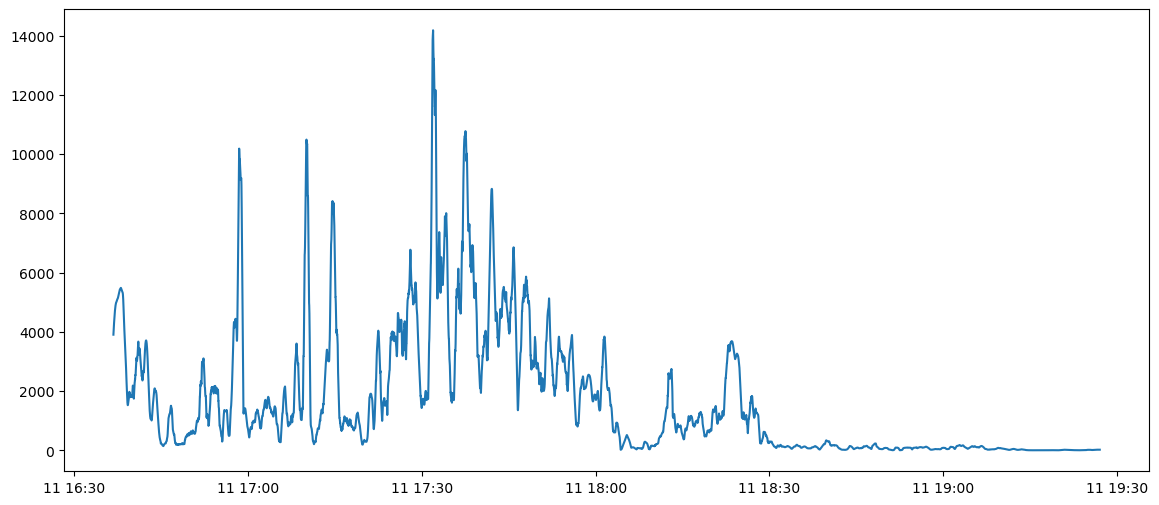

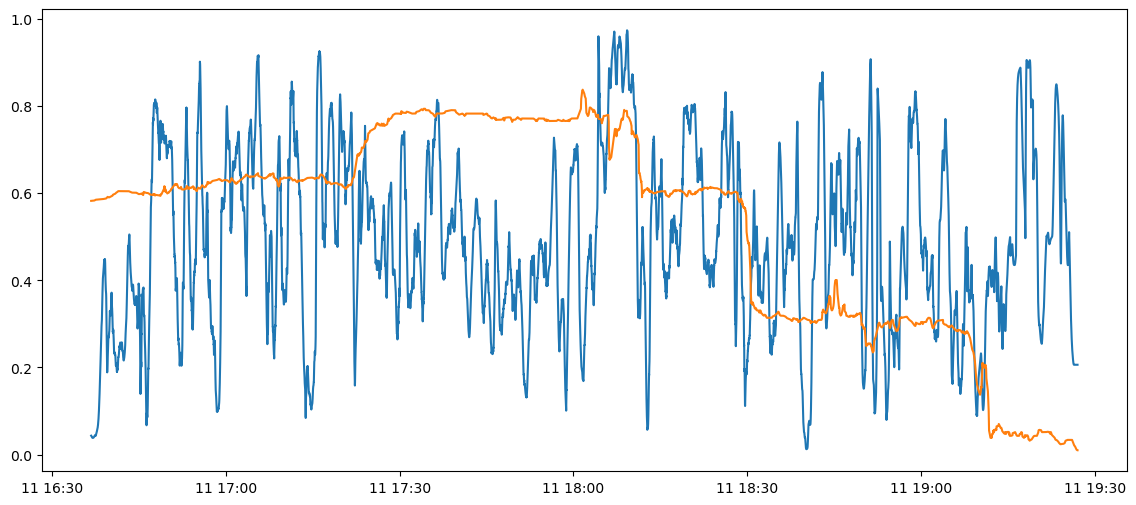

In [10]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['lay vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

                         lpt odds  r1 spread    r1 pup  r2 spread    r2 pup
2018-07-11 16:36:43.500  0.582314   0.004760  0.043435   0.028021  0.104394
2018-07-11 16:36:44.000  0.582323   0.004714  0.043357   0.028046  0.105942
2018-07-11 16:36:44.500  0.582332   0.004770  0.043234   0.027911  0.107337
2018-07-11 16:36:45.000  0.582341   0.004923  0.043072   0.027702  0.108568
2018-07-11 16:36:45.500  0.582350   0.005168  0.042874   0.027686  0.109633
...                           ...        ...       ...        ...       ...
2018-07-11 19:27:00.000  0.009950   1.598630  0.206208   0.026490  0.706074
2018-07-11 19:27:00.500  0.009950   1.598052  0.206208   0.026918  0.707305
2018-07-11 19:27:01.000  0.009950   1.597533  0.206208   0.027347  0.708770
2018-07-11 19:27:01.500  0.009950   1.597073  0.206208   0.027775  0.710624
2018-07-11 19:27:02.000  0.009950   1.596672  0.206208   0.028202  0.712852

[20438 rows x 5 columns]


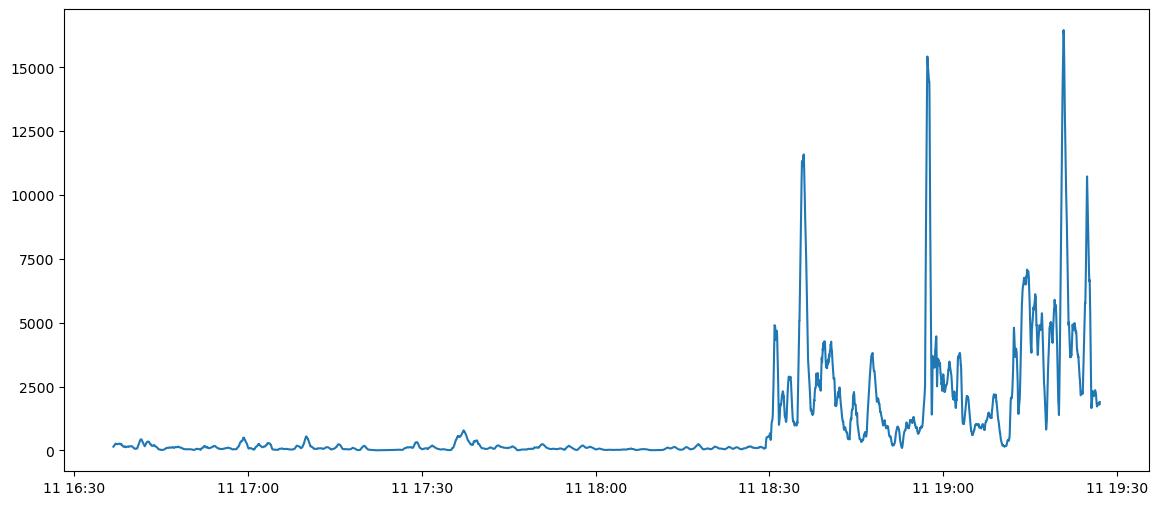

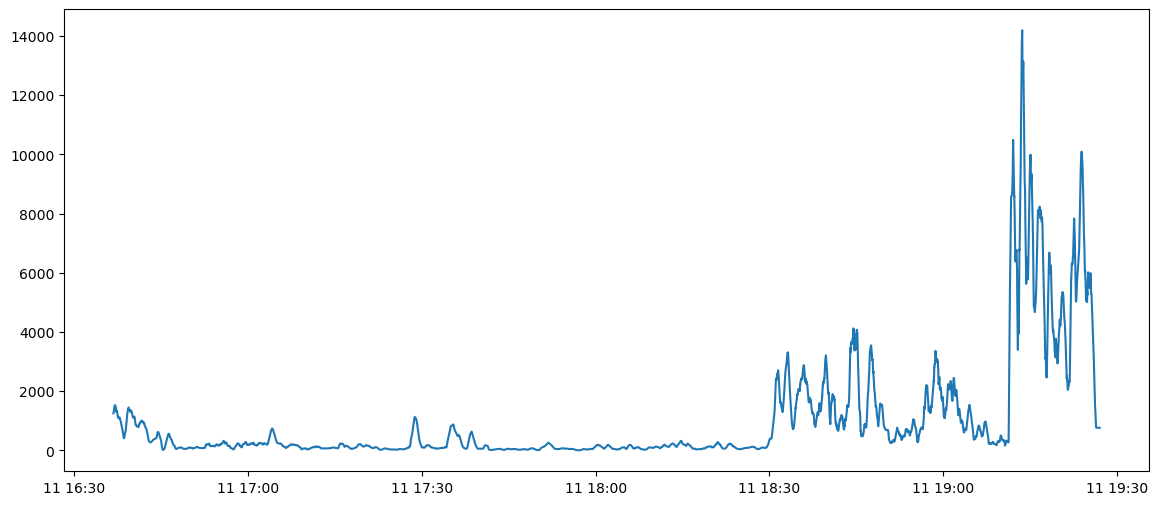

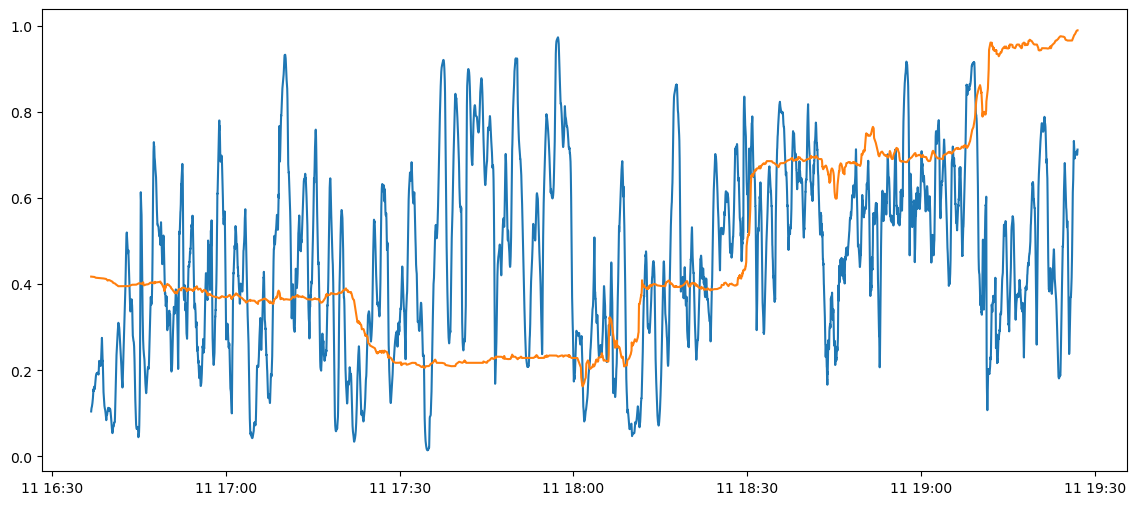

In [15]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['lay vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup']}, index=df_odds.index)
print(df_total)
df_total.to_csv('Data/1.csv')